In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed


import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# set up models and mesh

In [3]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0] # 15, 30, 45]
target_z = np.r_[-200, -20]

In [4]:
def diffusion_distance(sigma, t):
    return 1260*np.sqrt(t/sigma)

In [5]:
diffusion_distance(sigma_target, 8e-3)

np.float64(504.0)

In [6]:
diffusion_distance(sigma_back, 8e-3)

np.float64(2520.0)

In [7]:
tx_height = np.r_[30]

rx_x = np.r_[0] #(np.linspace(-500, 500, 51) + 5)
rx_y = np.r_[0]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

array([0])

In [8]:
base_cell_width = 10
domain_extent = 8000

n_base_cells = 2 ** int(
    np.ceil(np.log(domain_extent / base_cell_width) / np.log(2.0))
)  # needs to be powers of 2 for the tree mesh

h = [(base_cell_width, n_base_cells)]
mesh = discretize.TreeMesh([h, h, h], origin="CCC", diagonal_balance=True)

# refine near transmitters and receivers
mesh.refine_points(
    rx_locs, level=-1, padding_cells_by_level=[2, 2, 4], 
    finalize=False, diagonal_balance=True
)

# Refine core region of the mesh 

bounding_points = np.array([
    [-500, rx_y.min(), target_z.min() - base_cell_width * 4], 
    [500, rx_y.max(), 0],
])
mesh.refine_bounding_box(
    bounding_points, level=-1, 
    diagonal_balance=True, finalize=False, padding_cells_by_level=[2, 8, 8]
)

mesh.finalize()

In [9]:
mesh

OcTreeMesh,0.01% filled
Level,Number of cells
3,448
4,392
5,624
6,1568
7,2772
8,43744
9,42620
10,27680
Total,119848


In [10]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [11]:
models = {}

target_x = np.r_[-400, 400]
target_y = np.r_[-500, 500]
target_z_center = -60
target_thickness = 40

# background model
background = np.ones(mesh.n_cells) * sigma_air
background[mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        mesh, target_x_center=-100, target_z_center=target_z_center, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=target_x, 
        target_ylim=target_y,
        target_zlim=np.r_[-200, -20]
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



In [12]:
indices

array([False, False, False, ..., False, False, False])

In [13]:
model_keys = list(models.keys())
model_keys

['background', 'target_0']

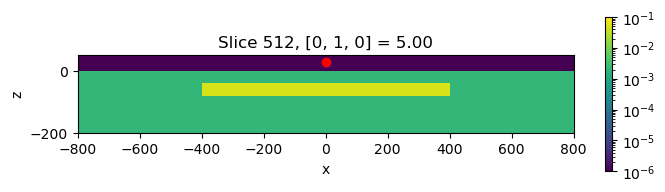

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

plt.colorbar(
    mesh.plot_slice(
        models["target_0"], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-6, 1e-1)},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(800*np.r_[-1, 1])
ax.set_ylim(np.r_[-200, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

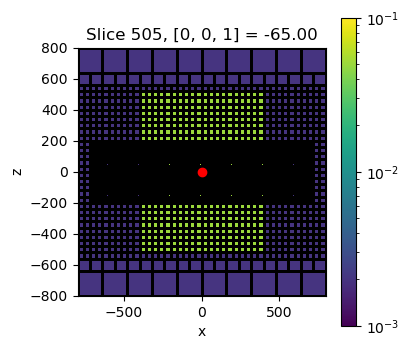

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4)) 

# mesh_local = mesh_list[-1]

plt.colorbar(
    mesh.plot_slice(
        models["target_0"], 
        grid=True, 
        normal="z",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax,
        ind=505
    )[0], 
    ax=ax
)

xlim = 800*np.r_[-1, 1]
ax.set_xlim(xlim)
ax.set_ylim(xlim)

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "ro")
ax.set_aspect(1)


In [16]:
log_conductivity_models = {}

active_cells = mesh.cell_centers[:, 2] < 0

for key, val in models.items():
    log_conductivity_models[key] = np.log(val[active_cells])

In [17]:
def get_sim():
    # set up survey
    rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)
    
    source_list = []

    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    survey = tdem.Survey(source_list)

    # create simulation 
    time_steps = [
        (1e-6, 30), (3e-6, 30), (1e-5, 30), (3e-5, 20), (1e-4, 20), (3e-4, 20)
    ]   
    msh = mesh.copy()
    active_cells_map = maps.InjectActiveCells(msh, msh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

    global_sim = tdem.simulation.Simulation3DElectricField(
        mesh=msh,
        survey=survey,
        time_steps=time_steps,
        solver=Solver,
        sigmaMap=maps.ExpMap() * active_cells_map
    )
    return global_sim

In [18]:
def run_simulation(key):
    print(f"Starting {key}")
    t = time.time()
    model = log_conductivity_models[key]
    sim = get_sim()
    dpred = sim.dpred(model)
    elapsed = time.time() - t
    print(f".... done. Elapsed time = {elapsed:1.2e}s \n")
    return key, dpred

In [19]:
dpred_dict = {}

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(run_simulation, key) for key in model_keys]
    for future in as_completed(futures):
        key, dpred = future.result()
        dpred_dict[key] = dpred

Starting background
Starting target_0


/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/em/static/wholespace.py:608: RuntimeWarning: invalid value encountered in divide
  rho[small_rho]**3 * 3 * a**2 / ( a ** 2 - 4 * z[small_rho]**2) / (
/home/lheagy/miniforge3/e

.... done. Elapsed time = 1.83e+02s 

.... done. Elapsed time = 1.84e+02s 



In [20]:
target_z

array([-200,  -20])

In [21]:
rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)
rx1d = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs, rx_times, orientation="z")
src1d = tdem.sources.CircularLoop(
    receiver_list=[rx1d], location=rx_locs, orientation="z", radius=10, 
    waveform=tdem.sources.StepOffWaveform()
)

survey1d = tdem.Survey([src1d])

models1d = {
    "background": np.log(1/rho_back) * np.ones(3), 
    "target_0": np.log(1/np.r_[rho_back, rho_target, rho_back])
}

true_thicknesses = np.r_[-target_z_center - target_thickness/2, target_thickness]
mesh_true = discretize.TensorMesh([(np.r_[true_thicknesses, true_thicknesses[-1]])], origin="0")

simulation1d = tdem.Simulation1DLayered(
    survey=survey1d, thicknesses=true_thicknesses, sigmaMap=maps.ExpMap(mesh_true)
)

true_thicknesses

array([40., 40.])

In [22]:
data1d = {
    key: simulation1d.dpred(val) for key, val in models1d.items()
}

In [23]:
# fig, ax = plt.subplots(1, 1) 

# for i, k in enumerate(list(data1d.keys())): 
#     ax.loglog(rx_times, -data1d[k])

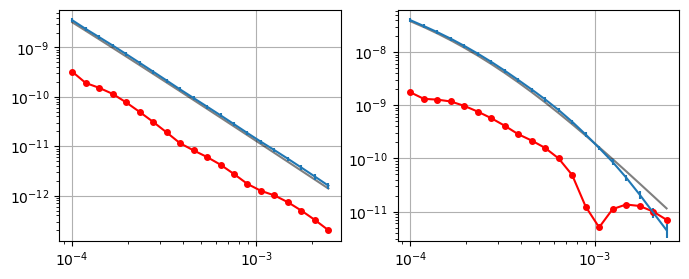

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3)) 
tend = 20

for i, k in enumerate(list(data1d.keys())): 
    ax[i].loglog(rx_times[:tend], -data1d[k][:tend], color="k", alpha=0.5)
    ax[i].errorbar(
        rx_times[:tend], -dpred_dict[k][:tend], yerr=0.1*np.abs(data1d[k][:tend])+1e-13, color="C0",
    )
    ax[i].loglog(rx_times[:tend], np.abs(-data1d[k]+dpred_dict[k])[:tend], "-ro", ms=4)
    ax[i].grid()

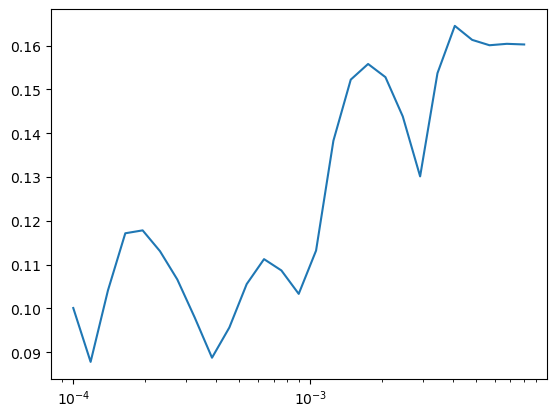

In [26]:
k = "background"
# k = "target_0"

plt.semilogx(rx_times, np.abs(-data1d[k]+dpred_dict[k])/ np.abs(data1d[k]))